Prompt:
Trump last month seized control of Washington, D.C.’s police department and deployed hundreds of National Guard troops and other federal agents to the nation’s capital, citing a crime emergency. He has used crime to justify the federal government’s intervention. He’s also sent the Guard into Memphis and said he plans to eventually carry out similar operations in New Orleans, Chicago and Baltimore, but is facing pushback from Democratic governors.

we are using FBI “Offenses Known to Law Enforcement” data (2020–2024) to see whether Trump’s claims are truthful and align with the actual crime rates. we will compare data for five years to understand how crime has changed over the years and also understand how crime in Washinton D.C., Memphis, New Orleans, Chicago and Baltimore compare to national avergaes to fully examine Trump’s “crime emergency” narrative.


Questions to Answer

1. Are violent crime rates actually increasing in the cities where Trump has deployed or plans to deploy federal forces (Washington, Memphis, New Orleans, Chicago, Baltimore)?

2. How do these cities compare to national trends in violent and property crime from 2020–2024?

3. Which types of crime (murder, robbery) are spiking the crime rate if it is actually increasing.

4. All these cities are lead by democrates, could that be the reason for chosing these cities or crime rate is actually high.

5. How does these cities demographic situation look like. Median household income and poverty rates. this data should be interrutped with context because it can be used politically. 

6. U.S. national guard members by year.



,label,Year,Violent crime,Population,violent_rate_per_100k
3,Chicago,2020,26583.0,2693598.0,986.895595
7,Memphis,2020,15310.0,650937.0,2351.994125
12,New Orleans,2020,5215.0,393779.0,1324.346905
15,"Washington, DC",2020,6828.0,712816.0,957.890956
8,Memphis,2021,15785.0,649444.0,2430.540585
0,Baltimore,2022,8861.0,570546.0,1553.073722
4,Chicago,2022,14321.0,2652124.0,539.982293
9,Memphis,2022,15129.0,624944.0,2420.856909
13,New Orleans,2022,5345.0,370128.0,1444.095016
16,"Washington, DC",2022,5003.0,671803.0,744.712364


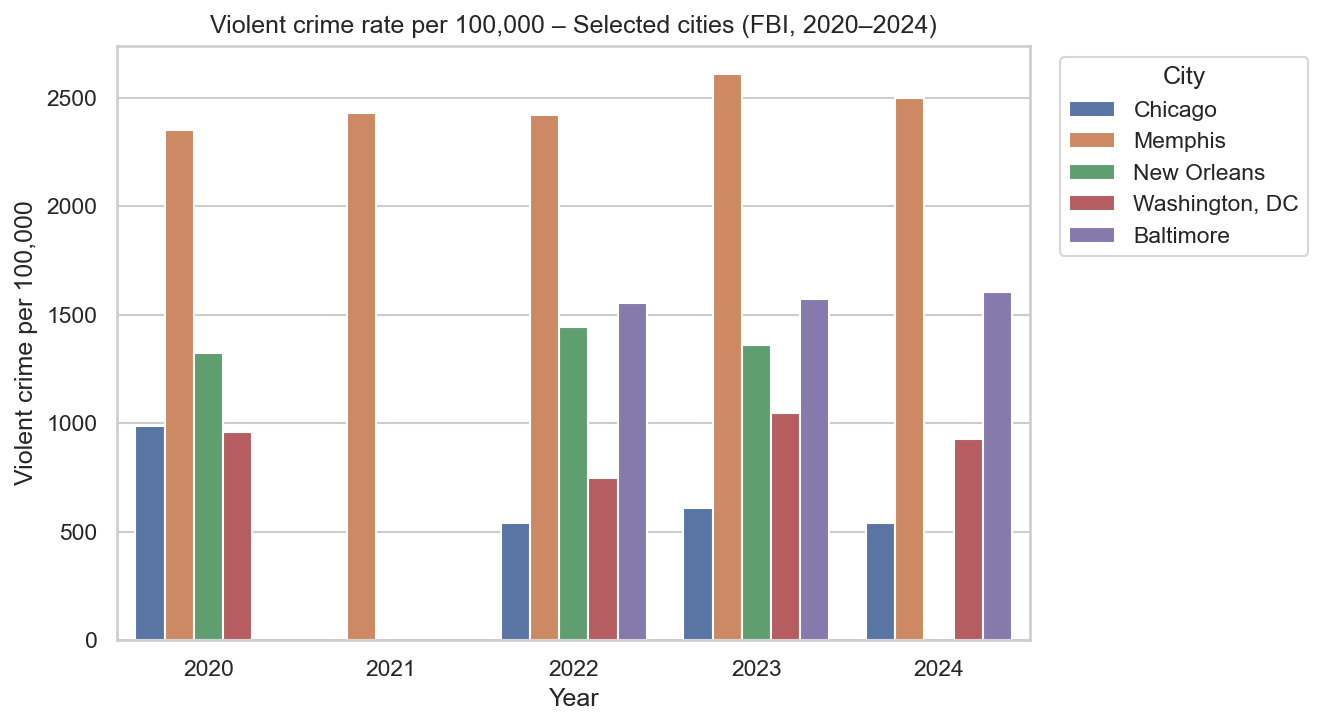

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

root = globals().get("PROJECT_ROOT", Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd())
DATA_PROCESSED = globals().get("DATA_PROCESSED", root / "data" / "processed")
OUT_CHARTS = globals().get("OUT_CHARTS", root / "output" / "charts")
SAVE_OUTPUT = globals().get("SAVE_OUTPUT", False)

csv_path = DATA_PROCESSED / "offenses_by_2020_2024_clean.csv"
df = pd.read_csv(csv_path)


def pick(df, options):
    for c in options:
        if c in df.columns:
            return c
    raise KeyError(f"None of the columns found: {options}")

state_col = pick(df, ["State"]) 
city_col = pick(df, ["City"])   
year_col = pick(df, ["Year"])  
violent_col = pick(df, ["Violent crime", "Violent Crime Total"]) 
pop_col = pick(df, ["Population"]) 


targets = [
    {"state": "DISTRICT OF COLUMBIA", "city": "WASHINGTON",   "label": "Washington, DC"},
    {"state": "TENNESSEE",            "city": "MEMPHIS",     "label": "Memphis"},
    {"state": "LOUISIANA",            "city": "NEW ORLEANS", "label": "New Orleans"},
    {"state": "ILLINOIS",             "city": "CHICAGO",     "label": "Chicago"},
    {"state": "MARYLAND",             "city": "BALTIMORE",   "label": "Baltimore"},
]

def up(s):
    return str(s).strip().upper()

df["_State_norm"] = df[state_col].map(up)
df["_City_norm"] = df[city_col].map(up)
key_to_label = {(t["state"], t["city"]): t["label"] for t in targets}

mask_keys = list(zip(df["_State_norm"], df["_City_norm"]))
subset = df.loc[pd.Series(mask_keys).isin(key_to_label.keys())].copy()
subset["label"] = list(zip(subset["_State_norm"], subset["_City_norm"]))
subset["label"] = subset["label"].map(key_to_label)


agg = subset.groupby(["label", year_col], as_index=False)[[violent_col, pop_col]].sum(min_count=1)
agg["violent_rate_per_100k"] = (agg[violent_col] / agg[pop_col]) * 100000.0


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
agg_plot = agg.copy()
agg_plot[year_col] = agg_plot[year_col].astype(int)
sns.barplot(data=agg_plot, x=year_col, y="violent_rate_per_100k", hue="label", ax=ax)
ax.set_ylabel("Violent crime per 100,000")
ax.set_xlabel("Year")
ax.set_title("Violent crime rate per 100,000 – Selected cities (FBI, 2020–2024)")
ax.legend(title="City", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

if SAVE_OUTPUT:
    OUT_CHARTS.mkdir(parents=True, exist_ok=True)
    out_path = OUT_CHARTS / "violent_rate_5cities.png"
    fig.savefig(out_path)
    print("Saved chart:", out_path)


agg.sort_values([year_col, "label"]).head(10)